In [9]:
import re
import sys
import torch
import numpy as np
import pandas as pd

from tqdm import tqdm
from pathlib import Path
from collections import defaultdict

HOME = Path.cwd().parent
workspace = HOME / 'workspaces'

# Import from our code base
sys.path.append(str(HOME))
from src.data import BatteryData, CyclingProtocol
from src.utils import import_config
from src.builders import (
    TRAIN_TEST_SPLITTERS,
    LABEL_ANNOTATORS,
    FEATURE_EXTRACTORS
)

## Get scores

In [10]:
# # read score from workspace 
# import matplotlib.pyplot as plt
# datasets = ['matr_1', 'matr_2', 'hust', 'mix_100', 'mix_20']

# sklearn_baseline_names = [
#     'dummy',
#     'variance_model',
#     'discharge_model',
#     'full_model',
#     'ridge',
#     'pcr',
#     'plsr',
#     'svm',
#     'rf'
# ]
# nn_baseline_names = ['mlp', 'cnn', 'lstm']
# paths = []
# for name in sklearn_baseline_names:
#     paths.append('../workspaces/baselines/sklearn/' + name)

# for name in nn_baseline_names:
#     paths.append('../workspaces/baselines/nn_models/' + name)

# paths.append('../workspaces/ablation/diff_branch/batlinet/')

# name_map = {
#     'dummy': 'Training Mean',
#     'variance_model': '\"Var.\"',
#     'discharge_model': '\"Dis.\"',
#     'full_model': '\"Full.\"',
#     'ridge': 'Ridge',
#     'pcr': 'PCR',
#     'plsr': 'PLSR',
#     'svm': 'SVM',
#     'rf': 'RF',
#     'mlp': 'MLP',
#     'cnn': 'CNN',
#     'lstm': 'LSTM',
#     'Ours': 'BatLiNet'
# }

# ori_name = sklearn_baseline_names + nn_baseline_names + ['Ours']

# methods = [name_map[i] for i in ori_name]

# metrics = ['RMSE', 'MAPE']

# scores = {}
# for metric in ['RMSE', 'MAPE']:
#     scores[metric] = {}
#     for dataset in datasets:
#         dataset_paths = [Path(x) / dataset for x in paths]
#         scores[metric][dataset] = {}

#         for indx, (path, method) in enumerate(zip(
#             dataset_paths, methods
#         )):
#             rmses = []

#             for log_file in path.glob('log.*'):
#                 with open(log_file, 'r') as f:
#                     rmse = float(re.findall(fr'{metric}: ([\d.]+)', f.read())[0])
#                 rmses.append(rmse)

#             if len(rmses) == 1:
#                 scores[metric][dataset][method] = np.array(rmses * 8)

#             else:
#                 scores[metric][dataset][method] = np.array(rmses)

# correct_MAPE_value = [['"Var."', 'matr_1', '0.15'],
# ['"Var."', 'matr_2', '0.12'],
# ['"Dis."', 'matr_1', '0.8'],
# ['"Dis."', 'matr_2', '0.11'],
# ['"Full."', 'matr_1', '0.11'],
# ['"Full."', 'matr_2', '0.12'],
# ['Ridge', 'matr_1', '0.13'],
# ['Ridge', 'matr_2', '0.11'],
# ['PCR', 'matr_1', '0.11'],
# ['PCR', 'matr_2', '0.11'],
# ['PLSR', 'matr_1', '0.10'],
# ['PLSR', 'matr_2', '0.11'],
# ['RF', 'matr_1', '0.15'],
# ['RF', 'matr_2', '0.11'],
# ]

# for [model, data, value] in correct_MAPE_value:
#     print(model, data, value)
#     scores['MAPE'][data][model] = np.array([float(value)] * 8)
# correct_value = [['"Var."', 'matr_1', '138'],
# ['"Var."', 'matr_2', '196'],
# ['"Dis."', 'matr_1', '86'],
# ['"Dis."', 'matr_2', '173'],
# ['"Full."', 'matr_1', '100'],
# ['"Full."', 'matr_2', '214'],
# ['Ridge', 'matr_1', '125'],
# ['Ridge', 'matr_2', '188'],
# ['PCR', 'matr_1', '100'],
# ['PCR', 'matr_2', '176'],
# ['PLSR', 'matr_1', '97'],
# ['PLSR', 'matr_2', '193'],
# ['RF', 'matr_1', '140'],
# ['RF', 'matr_2', '202'],
# ]

# for [model, data, value] in correct_value:
#     print(model, data, value)
#     scores['RMSE'][data][model] = np.array([float(value)] * 8)

# scores['MAPE']
# for dataset in scores['MAPE']:
#     for model in scores['MAPE'][dataset]:
#         scores['MAPE'][dataset][model] *= 100

In [77]:
# import pickle

# with open(os.path.join(HOME, 'data/scores.pkl'), 'wb') as file:
#     pickle.dump(scores, file)


In [78]:
import pickle

with open(os.path.join(HOME, 'data/scores.pkl'), 'rb') as file:
    scores = pickle.load(file)

# Multiple subgraphs

In [80]:
# multiple figure

def sub_error_bar_box_plot(ax, scores, dataset,metric = 'RMSE'):
    data = scores[metric][dataset]
    training_mean = data['Training Mean']

    # Separate the data
    scatter_data = {key: value for key, value in data.items() if key != 'Training Mean' and list(data.keys()).index(key) <= 8}
    boxplot_data = {key: value for key, value in data.items() if key != 'Training Mean' and list(data.keys()).index(key) > 8}

    # Create DataFrame for scatter data
    df_scatter = pd.DataFrame(scatter_data)
    df_scatter = pd.melt(df_scatter, var_name='Method', value_name=metric)
    df_scatter['Type'] = 'Scatter'

    # Create DataFrame for boxplot data
    df_boxplot = pd.DataFrame(boxplot_data)
    df_boxplot = pd.melt(df_boxplot, var_name='Method', value_name=metric)
    df_boxplot['Type'] = 'Boxplot'
    df_combined = pd.concat([df_scatter, df_boxplot])

    # # Combine all data into a single DataFrame
    # all_data = {key: value for key, value in data.items() if key != 'Training Mean'}
    # df_all = pd.DataFrame(all_data)
    # df_all = pd.melt(df_all, var_name='Method', value_name=metric)

    # Get the order of the methods
    # method_order = list(data.keys())[1:]
    method_order = ['"Var."','"Dis."', '"Full."', 'Ridge', 'PCR', 'PLSR', 'SVM', 'RF', 'MLP', 'LSTM', 'CNN', 'BatLiNet']

    # Bar plot for all methods
    sns.barplot(x='Method', y=metric, data=df_combined[df_combined['Type'] == 'Scatter'], order=method_order, palette='muted', errorbar='sd', alpha=0.7, ax=ax)
    sns.boxplot(x='Method', y=metric, data=df_combined[df_combined['Type'] == 'Boxplot'], palette='pastel', showmeans=False, zorder=1, order=method_order, ax=ax)

    # Add jittered data points for the box plot
    sns.stripplot(x='Method', y=metric, data=df_combined[df_combined['Type'] == 'Boxplot'], color='black', alpha=0.5, jitter=True, order=method_order, ax=ax)

    # Add the horizontal dashed line
    ax.plot([-0.5, len(method_order) - 0.5], [training_mean, training_mean], lw=1.5, linestyle='--', color='gray', label=f'Training Mean as Prediction: {training_mean}')
    
    # y = training_mean[0]
    # h = 2 if metric == 'RMSE' else 0.2
    # ax.text(1, y - h, f"Training Mean as Prediction: {y}", ha='center', va='bottom', color='grey')


    # # Customize plot
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yscale('log')

    default_max = 1000 if metric == 'RMSE' else 100
    default_delta = 10
    max_value = df_combined[metric].max()
    ylim = default_max if max_value > default_max else max_value
    ylim = training_mean[0]+default_delta  if training_mean[0] > ylim else ylim
    ax.set_ylim(0,ylim)


/home/xiaofangui/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/xiaofangui/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_2741210/2148217950.py:56: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,ylim)
/home/xiaofangui/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/xiaofangui

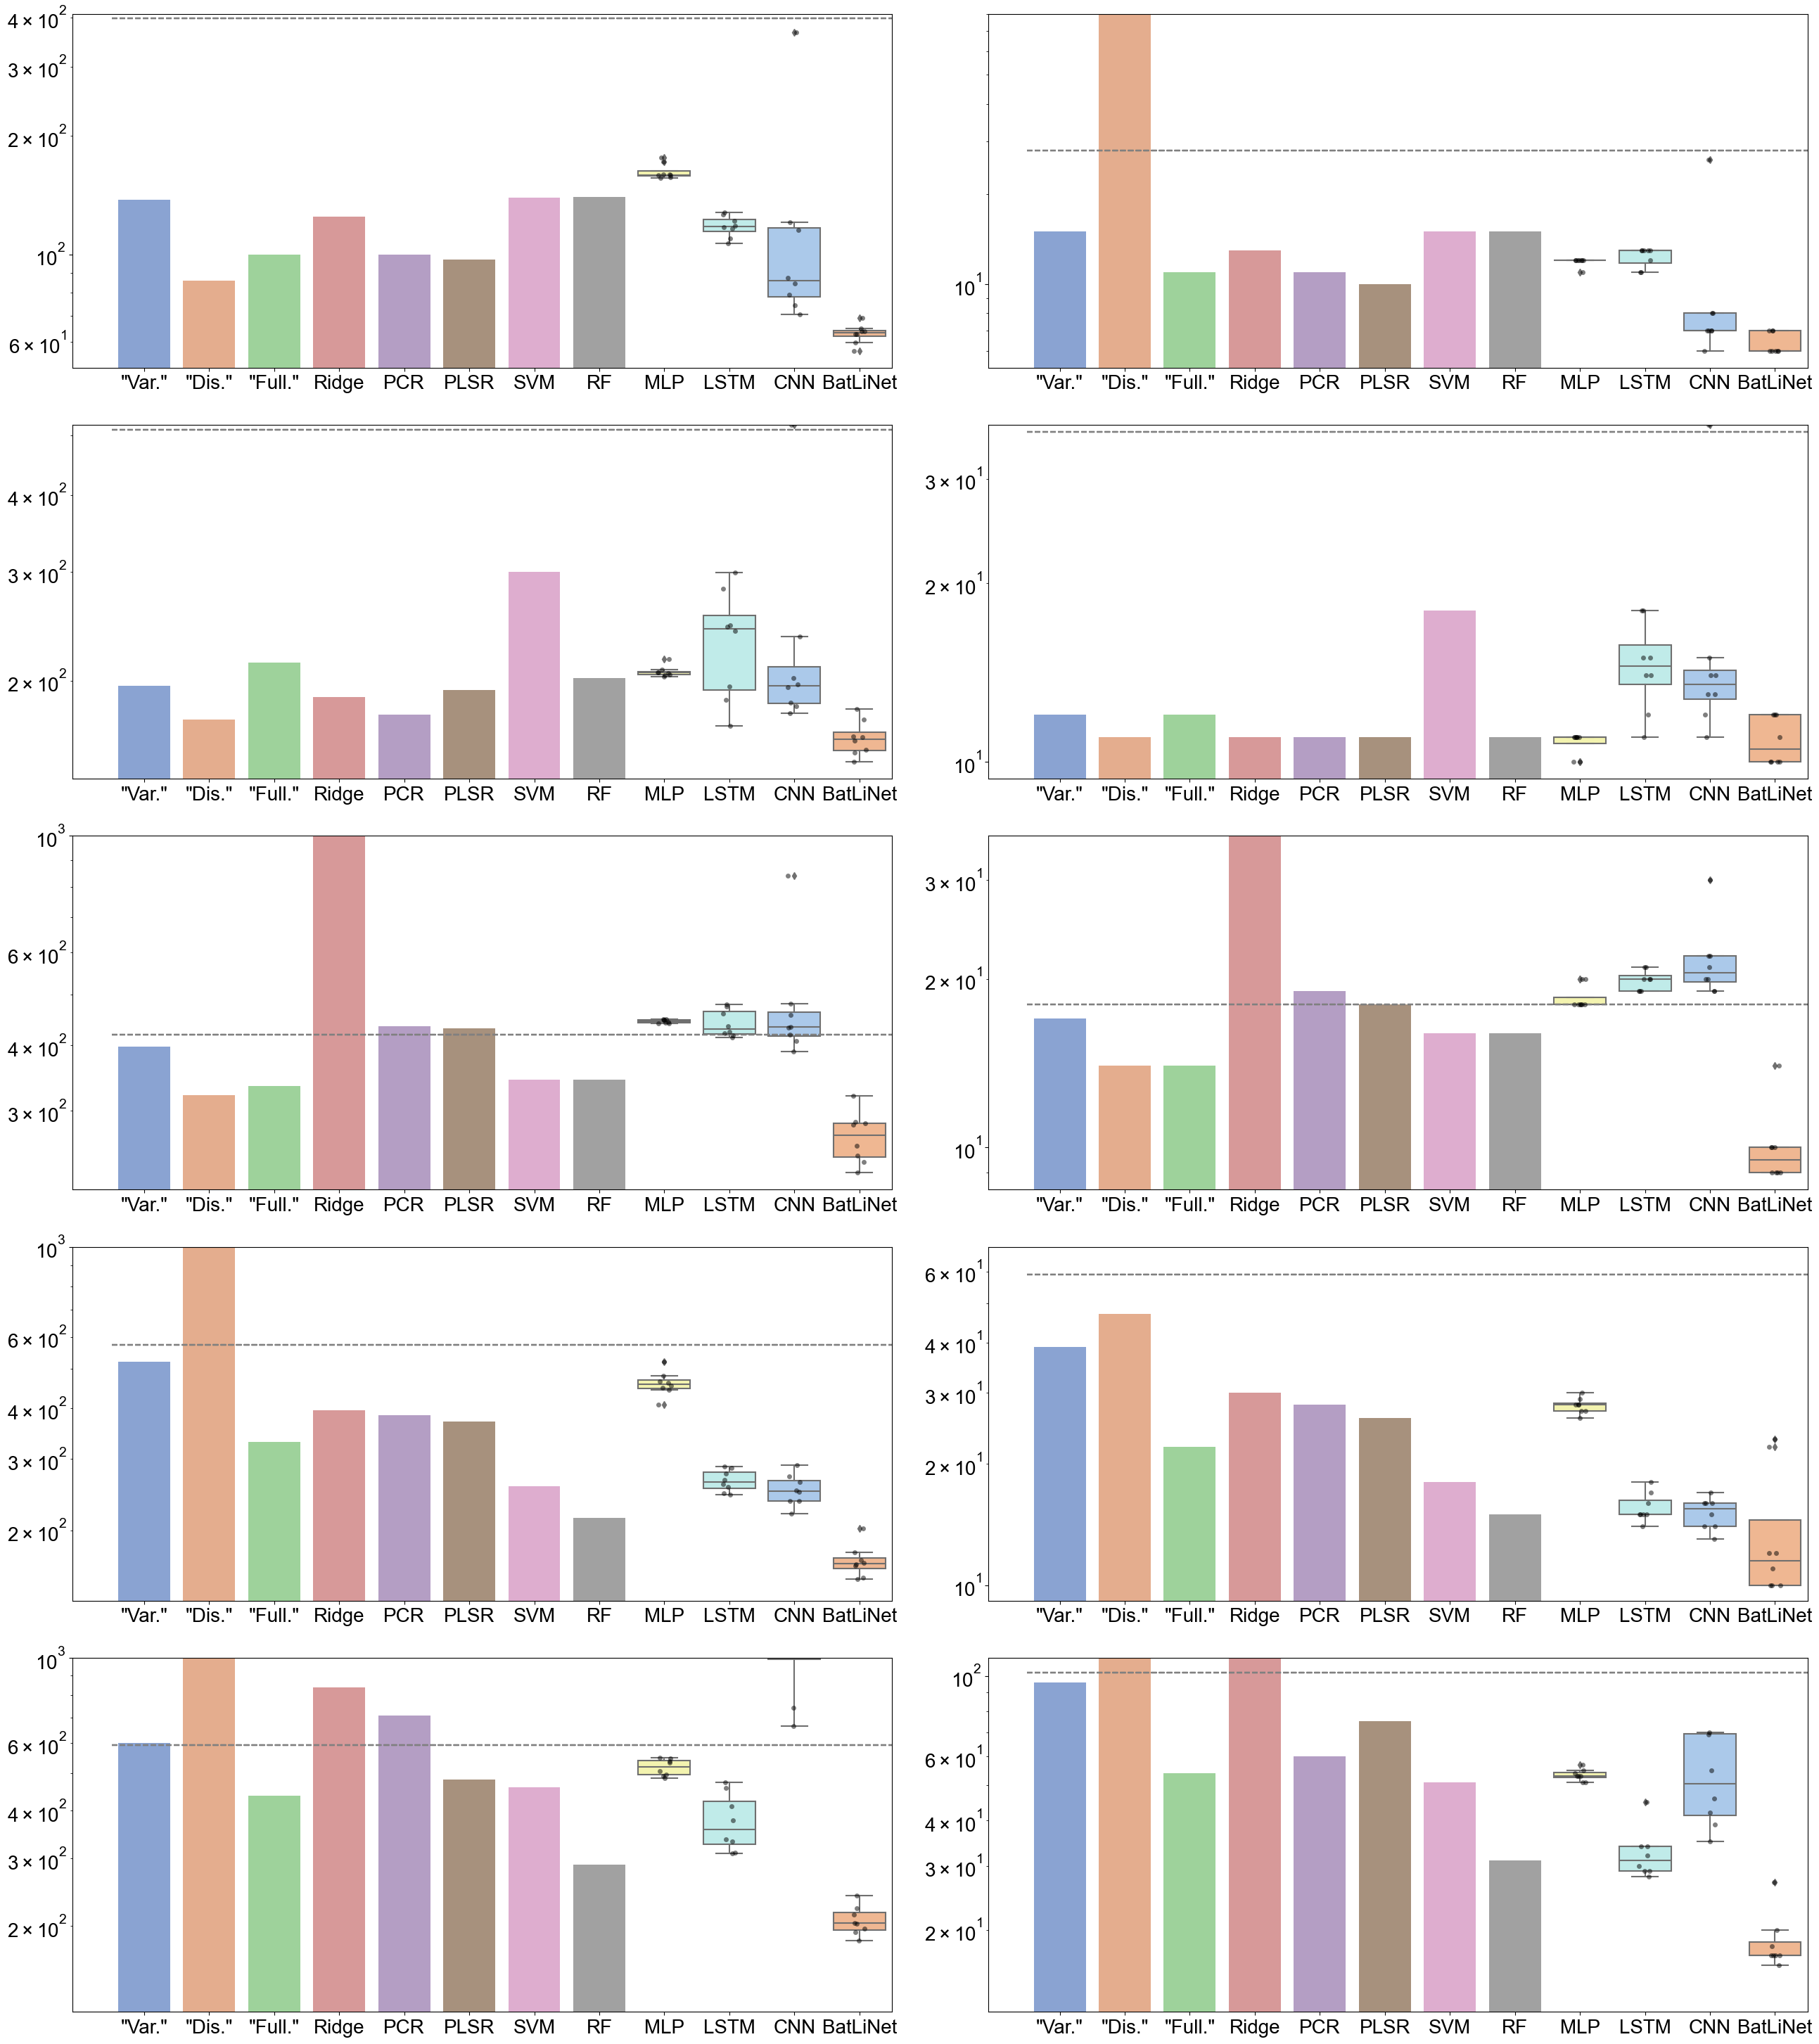

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# calculate based on the figure requirements, 180mm*200mm
FIGURE_HEIGHT = 7.87
FIGURE_WIDTH = 7.09
FONT_SIZE = 5
ratio = 4 # Zoom in 4 times to see the details clearly, and zoom out 4 times when importing ppt
MARGIN = 0.5
# Set font as Arial
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.weight'] = 'normal' 
plt.rcParams['font.size'] = FONT_SIZE * ratio


# Example data for plotting
data_list = [np.random.rand(10) for _ in range(10)]
titles = [f'Subplot {i+1}' for i in range(10)]

# Create a 5x2 grid of subplots
fig, axs = plt.subplots(5, 2, figsize=(FIGURE_WIDTH * ratio - MARGIN * ratio, FIGURE_HEIGHT*ratio - MARGIN * ratio))

# Flatten the axs array for easy iteration
axs = axs.flatten()
idx = 0
datasets = ['matr_1', 'matr_2', 'hust', 'mix_100', 'mix_20']
for dataset in datasets:
    for metric in ['RMSE', 'MAPE']:
        sub_error_bar_box_plot(axs[idx],scores,  dataset, metric = metric)
        idx += 1

# Adjust layout
plt.tight_layout()

plt.savefig(HOME / f'data/fig3.svg',
            bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.show()




# single figure 


In [ ]:
# single figure 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# Generate sample data
np.random.seed(42)

# Set a different font family
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.weight'] = 'normal' 
plt.rcParams['font.size'] = 20

def error_bar_box_plot(scores, dataset,metric = 'RMSE'):
    data = scores[metric][dataset]
    training_mean = data['Training Mean']

    # Separate the data
    scatter_data = {key: value for key, value in data.items() if key != 'Training Mean' and list(data.keys()).index(key) <= 8}
    boxplot_data = {key: value for key, value in data.items() if key != 'Training Mean' and list(data.keys()).index(key) > 8}

    # Create DataFrame for scatter data
    df_scatter = pd.DataFrame(scatter_data)
    df_scatter = pd.melt(df_scatter, var_name='Method', value_name=metric)
    df_scatter['Type'] = 'Scatter'

    # Create DataFrame for boxplot data
    df_boxplot = pd.DataFrame(boxplot_data)
    df_boxplot = pd.melt(df_boxplot, var_name='Method', value_name=metric)
    df_boxplot['Type'] = 'Boxplot'
    df_combined = pd.concat([df_scatter, df_boxplot])


    # Combine all data into a single DataFrame
    all_data = {key: value for key, value in data.items() if key != 'Training Mean'}
    df_all = pd.DataFrame(all_data)
    df_all = pd.melt(df_all, var_name='Method', value_name=metric)
    # Combine both DataFrames

    # Get the order of the methods
    # method_order = list(data.keys())[1:]
    method_order = ['"Var."','"Dis."', '"Full."', 'Ridge', 'PCR', 'PLSR', 'SVM', 'RF', 'MLP', 'LSTM', 'CNN', 'BatLiNet']
    # Create the plot
    plt.figure(figsize=(14, 6))

    # Bar plot for all methods
    sns.barplot(x='Method', y=metric, data=df_combined[df_combined['Type'] == 'Scatter'], order=method_order, palette='muted', errorbar='sd', alpha=0.7)
    sns.boxplot(x='Method', y=metric, data=df_combined[df_combined['Type'] == 'Boxplot'], palette='pastel', showmeans=False, zorder=1, order=method_order)

    # Add jittered data points for the box plot
    sns.stripplot(x='Method', y=metric, data=df_combined[df_combined['Type'] == 'Boxplot'], color='black', alpha=0.5, jitter=True, order=method_order)

    # Add the horizontal dashed line
    plt.plot([-0.5, len(method_order) - 0.5], [training_mean, training_mean], lw=1.5, linestyle='--', color='gray', label=f'Training Mean as Prediction: {training_mean}')
    # y = training_mean[0]
    # h = 0
    # plt.text(9, y + h, f"Training Mean as Prediction: {y}", ha='center', va='bottom', color=col)


    # # Customize plot
    plt.ylabel('')
    plt.xlabel('')
    plt.yscale('log')
    max_value = df_all[metric].max()
    ylim = 1000 if max_value > 1000 else max_value
    plt.ylim(0,ylim)

    plt.yticks([])
    plt.title(f'{dataset},{metric}')

    plt.savefig(HOME / f'data/{dataset}_{metric}.svg',
                bbox_inches='tight', pad_inches=0.1, transparent=True)

    plt.show()
# # single figure

# datasets = ['matr_1', 'matr_2', 'hust', 'mix_100', 'mix_20']
# for metric in ['RMSE', 'MAPE']:
#     for dataset in datasets:
#         error_bar_box_plot(scores, dataset,metric = 'RMSE')
#         break
#     break
        
    
